In [ ]:
pip install simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Streaming output truncated to the last 5000 lines.
Customer 2874 exit the shop at 19:09:33.
Customer 3099 enters shop at 19:09:37.
Customer 3100 enters shop at 19:09:41.
Customer 2911 goes to terminal 1 at 19:09:42.
Customer 2911 paying his buys at 19:09:42.
Customer 3010 gets 7 buys at 19:09:44.
Customer 3101 enters shop at 19:09:45.
Customer 3010 goes to terminal 2 at 19:09:54.
Customer 3010 paying his buys at 19:09:54.
Customer 2978 gets 5 buys at 19:09:57.
Customer 2881 gets 14 buys at 19:10:04.
Customer 3102 enters shop at 19:10:04.
Customer 2978 goes to terminal 3 at 19:10:07.
Customer 2978 paying his buys at 19:10:07.
Customer 2865 gets 15 buys at 19:10:08.
Customer 2881 goes to terminal 4 at 19:10:14.
Customer 2881 paying his buys at 19:10:14.
Customer 2865 goes to terminal 0 at 19:10:18.
Customer 3010 payed his buys at 19:10:27.
Customer 3010 exit the shop at 19:10:27.
Customer 2911 payed his buys at 19:10:30.
Customer 2911 exit the shop at 19:10:30.
Customer 3103 enters shop 

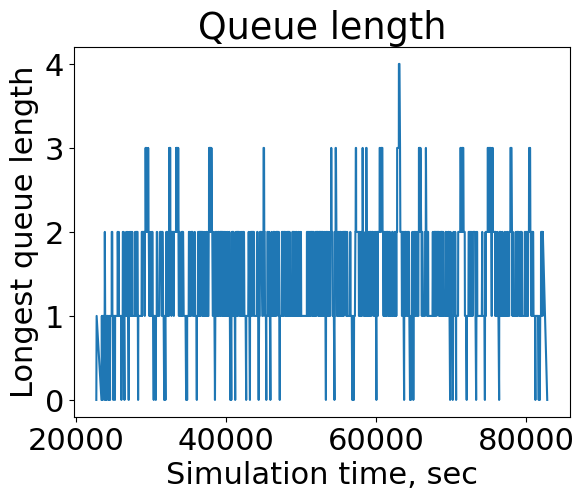

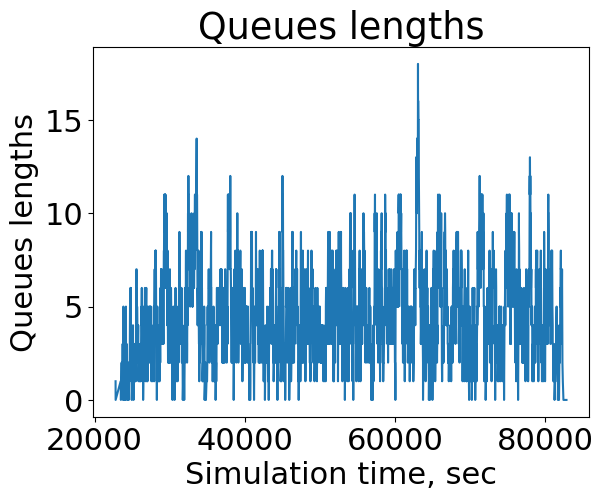

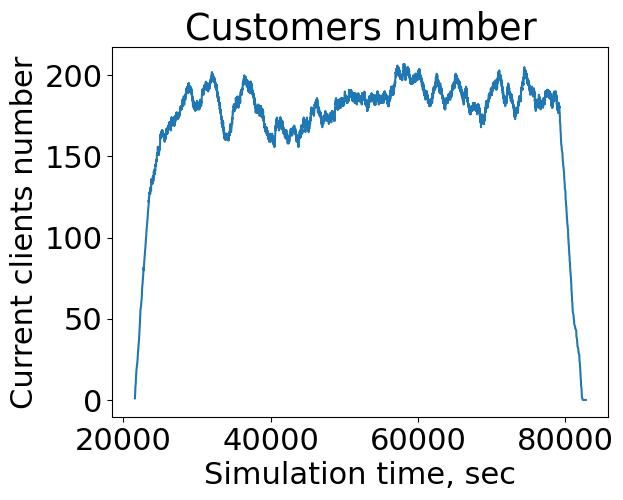

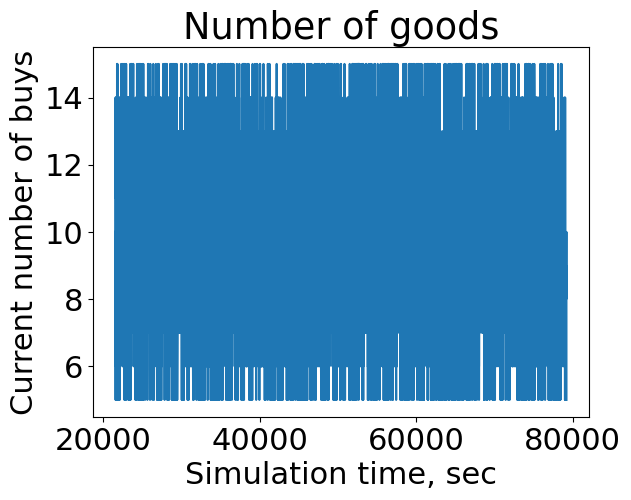

In [ ]:
import random
import locale
import simpy
from termcolor import cprint
from time import sleep

# You can change constants
SHOP_OPEN_TIME = 6*3600 # Shop opens at 6:00AM
SHOP_CLOSE_TIME = 23*3600 # Shop closes at 11:00PM
ANNOUNCE_CLOSE = 10*60 # The shop announces closing 10 minutes before
CLOSE_ENTER = 60 # The shop enter closes 60 minutes before shop close
AVG_ENTER_TIME = 15 # A customer enters every ~15 seconds
AVG_BUYS_NUBMER = 10 # A customer buys ~10 goods
NUM_TERMINAL = 5 # Number of pay terminals in the shop

DRAW = True # Shows graph

# Statistic | Variable globals
num_clients = 0 # Number customers in the shop right now
clients = [] # Array of clients number
timestat_c = [] # Time statistic for clients
len_queue = 0 # Queue length right now (longest)
queues = [] # Array of queue lengths
timestat_q = [] # Time statistic for queues
goods = [] # Array of goods bought by customers
timestat_g = [] # Time statistic for goods
len_all_queues = 0 # Sum of queues lengths
all_queues = [] # Array of all queues in the shop
timestat_aq = [] # Time statistic for all queues

additional_time = 0 # Shop works additonal time if there are people inside
slow_flag = False # Simulation speed

# D_enter
def enter_time(): # customer entering every 'D_enter' seconds
    return random.randint(0, AVG_ENTER_TIME*2)

# D_num
def buys_num(): # customer buying 'D_num' goods
    left = int(AVG_BUYS_NUBMER - AVG_BUYS_NUBMER/2)
    right = int(AVG_BUYS_NUBMER + AVG_BUYS_NUBMER/2)
    return random.randint(left, right)
# D_time
def buy_time(): # customer spending 'D_time' seconds buying one buy
    time_per_one_buy = random.randint(3, 6) * 60 # ~3-6 minutes
    return time_per_one_buy

# D_pay
def pay_time(): # cashier spending 'D_pay' seconds on one buy
    time_per_one_buy = random.randint(2, 8)
    return time_per_one_buy

# Get current time hh::mm::ss
def format_time(stime):
    # return str(stime) # just 4 test
    if stime == 0:
        return "00:00:00"
    hours = int(stime / 3600) % 24
    minutes = int(stime % 3600 / 60)
    seconds = int(stime % 3600 % 60)
    if hours < 10:
        hours = "0" + str(hours)
    if minutes < 10:
        minutes = "0" + str(minutes)
    if seconds < 10:
        seconds = "0" + str(seconds)
    return str(hours) + ":" + str(minutes) + ":" + str(seconds)


# The shop
class Shop(object):
    def __init__(self, env, num_terminals):
        self.env = env
        self.num_terminals = num_terminals
        self.terminals = [] # = cashboxes
        self.queue = [] # queue length at terminal
        self.cashier_speed = [] # cashier time per one buy
        for i in range(num_terminals):
            # Only one customer can servicing at one time
            self.terminals.append(simpy.Resource(env, capacity=1))
            self.queue.append(simpy.Container(env,capacity=5000, init=0)) # no queues at the start
            self.cashier_speed.append(pay_time())

    def service(self, name, i, buys): # servicing client at cashbox
        global additional_time, len_all_queues
        print('%s paying his buys at %s.' % (name, format_time(self.env.now)))
        # service time = time for checking buys + time for paying
        service_time = self.cashier_speed[i]*buys + self.cashier_speed[i]*4
        if SHOP_CLOSE_TIME - self.env.now < service_time:
            additional_time = int(service_time*len_all_queues/NUM_TERMINAL)
        yield self.env.timeout(service_time)
        self.queue[i].get(1)
        print('%s payed his buys at %s.' % (name, format_time(self.env.now)))

    def choose_cashbox(self, name): # customer looking for cashbox with the smallest queue
        min_queue = self.queue[0].level
        max_queue = self.queue[0].level
        min_index = 0
        for i in range(self.num_terminals):
            if self.queue[i].level < min_queue:
                min_queue = self.queue[i].level
                min_index = i
            if self.queue[i].level > max_queue:
                max_queue = self.queue[i].level
        self.queue[min_index].put(1)
        global timestat_q, queues
        queues.append(max_queue)
        timestat_q.append(self.env.now)
        print('%s goes to terminal %d at %s.' % (name, min_index, format_time(self.env.now)))
        return min_index


# Customer shopping
class Customer(object):
    def __init__(self, env, name, shop):
        self.env = env
        self.name = name
        self.shop = shop
        self.buys = buys_num() # number of goods that customer needs
        self.time_per_buy = buy_time() # time spending at one buy
        self.time_buy = self.buys * self.time_per_buy # time spending at all stuff
    def shopping(self):
        global clients, len_queue, queues, num_clients, goods, len_all_queues, slow_flag
        global timestat_c, timestat_g, timestat_q, timestat_aq
        # Check on enough time for buys
        time_before = SHOP_CLOSE_TIME - ANNOUNCE_CLOSE - self.env.now
        if time_before < 0:
            yield self.env.timeout(SHOP_CLOSE_TIME - self.env.now)
        if time_before < self.time_per_buy*self.buys:
            # customer get less goods that he wanted
            self.time_buy = -1 # cancel shopping if not enough time
            for i in range(self.buys-1):
                if time_before > self.time_per_buy*(self.buys-i):
                    self.buys = self.buys-i
                    self.time_buy = self.time_per_buy*self.buys
                    break
        if self.time_buy < 0: # interupt if not enough bying time
            yield self.env.timeout(SHOP_CLOSE_TIME - self.env.now)
        # Start shopping
        cprint('%s enters shop at %s.' % (self.name, format_time(self.env.now)), 'green')
        num_clients += 1
        clients.append(num_clients) # save values for graph
        timestat_c.append(self.env.now)
            # Customer doing buys
        goods.append(self.buys)  # save values for graph
        timestat_g.append(self.env.now)
        yield self.env.timeout(self.time_buy)
        print('%s gets %d buys at %s.' % (self.name, self.buys, format_time(self.env.now)))

            # Customer goes to pay terminals
        yield self.env.timeout(10) # ~10 seconds to go
            # Customer goes to terminal with the smalles queue
        choosen = self.shop.choose_cashbox(self.name)

            # Customer waits if terminal is busy
        len_all_queues += 1
        with self.shop.terminals[choosen].request() as request:
            yield request
            yield self.env.process(self.shop.service(self.name, choosen, self.buys))
            len_all_queues -= 1
            all_queues.append(len_all_queues) # save values for graph
            timestat_aq.append(self.env.now)
            cprint('%s exit the shop at %s.' % (self.name, format_time(self.env.now)),'red')
            num_clients -= 1
            clients.append(num_clients)
            timestat_c.append(self.env.now)
            if slow_flag:
                sleep(0.002)


# Create shop and cast customers
def simmulate(env):
    # Shop creating
    shop = Shop(env, NUM_TERMINAL)
    yield env.timeout(SHOP_OPEN_TIME) # Wait for shop openning
    cprint('Shop openning at %s.' % format_time(env.now),'yellow')
    sleep(1)
    # Customers entering the shop
    num = 0 # customer number
    time_before_close = SHOP_CLOSE_TIME - env.now
    while time_before_close > CLOSE_ENTER*60: # close enter one hour before closing
        num += 1
        if env.now - SHOP_OPEN_TIME < 5*60:
            sleep(0.1)
        yield env.timeout(enter_time()) # waiting for next customer enter
        # Creating process for every customer
        customer = Customer(env, 'Customer %d' % num, shop)
        shopping = env.process(customer.shopping())
        time_before_close = SHOP_CLOSE_TIME - env.now

    cprint('\nThe shop enter closed!\n', 'yellow')
    sleep(2)
    global slow_flag
    slow_flag =  True
    if time_before_close - ANNOUNCE_CLOSE > 0:
        yield env.timeout(time_before_close - ANNOUNCE_CLOSE)
    cprint('\nAnnounce: The shop closing soon!\n', 'red')
    sleep(2)

def main():
    cprint('Shop simulation starts:\n', 'green')
    random.seed()

    # Setup process
    env = simpy.Environment()
    inside = env.process(simmulate(env))
    sleep(1)
    # Execute
    env.run(until=SHOP_CLOSE_TIME)
    cprint('\nNumber of clients inside after shop close: %d. Shop worked %s above the normal' %
    (num_clients,format_time(additional_time)),'cyan')
    close_time = env.now + additional_time
    clients.append(0)
    timestat_c.append(close_time)
    queues.append(0)
    timestat_q.append(close_time)
    all_queues.append(0)
    timestat_aq.append(close_time)
    sleep(0.5)
    cprint('Shop closes at %s.' % format_time(env.now+additional_time), 'yellow')
    sleep(0.5)
    cprint('\nShop simulation stopped.', 'red')


if __name__ == "__main__":
    main()

from pylab import *


font = {'family' : 'Normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

figure('Timestat queue')
plot(timestat_q, queues)
title('Queue length')
xlabel(u'Simulation time, sec')
ylabel(u'Longest queue length')

figure('Timestat all queues')
plot(timestat_aq, all_queues)
title('Queues lengths')
xlabel(u'Simulation time, sec')
ylabel(u'Queues lengths')

figure('Timestat client')
plot(timestat_c, clients)
title(u'Customers number')
xlabel(u'Simulation time, sec')
ylabel(u'Current clients number')

figure('Timestat goods')
plot(timestat_g, goods)
title('Number of goods')
xlabel(u'Simulation time, sec')
ylabel(u'Current number of buys')
if DRAW:
    cprint('\nBuilding graphs...', 'blue')
    sleep(2)
    show()